In [167]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc


In [109]:
#Importing data from huggingface

from datasets import load_dataset

ds = load_dataset("Sri-Vigneshwar-DJ/marketing-leadsprediction")

In [111]:
#Convert to Pandas DataFrame
import pandas as pd
df = ds['train'].to_pandas()
print(df.head())
print(df.info())

  Conversion Data Lead Capture Type Lead Disposition  Lead Source Lead Stage  \
0             YES              None   Not Interested  FB Lead Ads   New Lead   
1            None              None    Not Connected  FB Lead Ads   New Lead   
2            None              None     Disqualified  FB Lead Ads   New Lead   
3             YES              None    Not Connected  FB Lead Ads   New Lead   
4             YES              None    Not Connected  FB Lead Ads   New Lead   

  Registered           State Student Grade     Student Stream  Total Calls  \
0       None       Karantaka           YES  science_with_math         15.0   
1       None             A P           YES               STEM          5.0   
2       None       tamilnadu           YES                COM          3.0   
3       None  Andhra Pradesh        DEGREE               None         36.0   
4       None       Karnataka        DEGREE               None         49.0   

   Total Connects  Lead Number    Created On  
0  

In [112]:
#Check Shape
print(df.shape)

(58972, 13)


In [113]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58972 entries, 0 to 58971
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Conversion Data    27059 non-null  object 
 1   Lead Capture Type  235 non-null    object 
 2   Lead Disposition   52729 non-null  object 
 3   Lead Source        58972 non-null  object 
 4   Lead Stage         58971 non-null  object 
 5   Registered         1478 non-null   object 
 6   State              58902 non-null  object 
 7   Student Grade      57173 non-null  object 
 8   Student Stream     282 non-null    object 
 9   Total Calls        58971 non-null  float64
 10  Total Connects     58970 non-null  float64
 11  Lead Number        58972 non-null  int64  
 12  Created On         58972 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 5.8+ MB
None


In [114]:
#Inspect Missing Values
print(df.isnull().sum())

Conversion Data      31913
Lead Capture Type    58737
Lead Disposition      6243
Lead Source              0
Lead Stage               1
Registered           57494
State                   70
Student Grade         1799
Student Stream       58690
Total Calls              1
Total Connects           2
Lead Number              0
Created On               0
dtype: int64


In [115]:
#identifying unique lead status
print(df['Lead Disposition'].unique())

print(df['Lead Stage'].unique())

['Not Interested' 'Not Connected' 'Disqualified' 'New' None
 'Appointment Fixed' 'Future Lead' 'Demo Conducted' 'Call Later'
 'Applied from different number' 'Language Barrier' 'Non-eligible stream'
 'Applied' 'New - Reactivated' 'Appointment Confirmed'
 'Not Interested - Lead' 'Interested in Webinar' 'Reactivated'
 'Appointment Cancelled' 'RNR' 'Switched Off' 'Wrong Number'
 'Not Interested - Applicant' 'Not Relevant' 'Cold']
['New Lead' None 'Admission Offered' 'Registered' 'Admission Accepted'
 'Elapsed' 'KQ Rejected' 'KQ Selected' 'Interview Not Cleared' 'Applied'
 'KQ Cleared' 'KQ Not Cleared' 'KQ Challenge Completed' 'Payment Done']


In [116]:
#Target Variable Clarification
# Step 2: Define Target Variable
df['Converted'] = df['Conversion Data'].apply(lambda x: 1 if x == 'YES' else 0)

# Check target balance
print(df['Converted'].value_counts(normalize=True))


Converted
0    0.541155
1    0.458845
Name: proportion, dtype: float64


In [117]:
#Drop High-Null and Irrelevant Columns
# Make a copy for safety
df_clean = df.copy()

# Drop high-null or irrelevant columns
df_clean = df_clean.drop(columns=[
    'Lead Number',          # Just an ID
    'Registered',           # >95% null
    'Lead Capture Type',    # >99% null
    'Student Stream'        # >99% null
])

print(df_clean.shape)


(58972, 10)


In [118]:
#Convert "Created On" to DateTime and Engineer Time Features
df_clean['Created On'] = pd.to_datetime(df_clean['Created On'], errors='coerce')

# Extract datetime components
df_clean['created_month'] = df_clean['Created On'].dt.month
df_clean['created_day'] = df_clean['Created On'].dt.day
df_clean['created_weekday'] = df_clean['Created On'].dt.dayofweek

# Drop original date column
df_clean = df_clean.drop(columns=['Created On'])

print(df_clean[['created_month', 'created_day', 'created_weekday']].head())


C:\Users\Roche\AppData\Local\Temp\ipykernel_17208\4228800291.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['Created On'] = pd.to_datetime(df_clean['Created On'], errors='coerce')


   created_month  created_day  created_weekday
0              4           17                2
1              1            8                0
2              6           15                5
3              6           18                1
4              6           19                2


In [120]:
#Handle Missing Values on numerical columns
# Fill missing with median
df_clean['Total Calls'] = df_clean['Total Calls'].fillna(df_clean['Total Calls'].median())
df_clean['Total Connects'] = df_clean['Total Connects'].fillna(df_clean['Total Connects'].median())


In [121]:
#Handle Missing Values on categorical columns
# Fill missing values in categorical columns with "Unknown"
cat_cols = df_clean.select_dtypes(include='object').columns
df_clean[cat_cols] = df_clean[cat_cols].fillna('Unknown')


In [122]:
#Encode Target Variable
df_clean['Converted'] = df_clean['Conversion Data'].apply(lambda x: 1 if x == 'YES' else 0)

# Drop original Conversion Data column
df_clean = df_clean.drop(columns=['Conversion Data'])

# Confirm
print(df_clean['Converted'].value_counts(normalize=True))


Converted
0    0.541155
1    0.458845
Name: proportion, dtype: float64


EDA Section.

This part will cover:
1 Check class balance in the target
2 Univariate analysis of key features
3 Bivariate analysis — features vs. target
4 Correlation analysis (numerical features)

In [123]:
import sys
print(sys.executable)


c:\Users\Roche\Desktop\Leads Churn Prediction\.venv\Scripts\python.exe


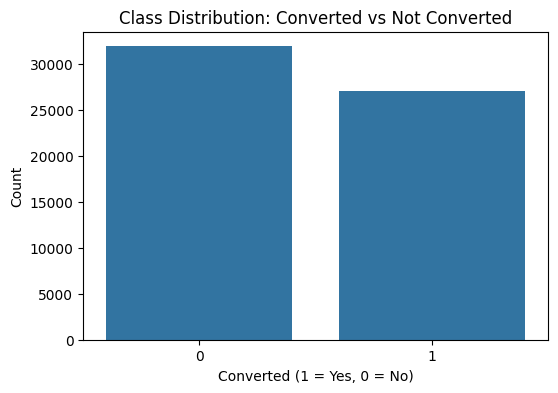

In [124]:
#Checking Class Balance
#visualize the balance of converted vs not converted leads
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=df_clean, x='Converted')
plt.title('Class Distribution: Converted vs Not Converted')
plt.xlabel('Converted (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()


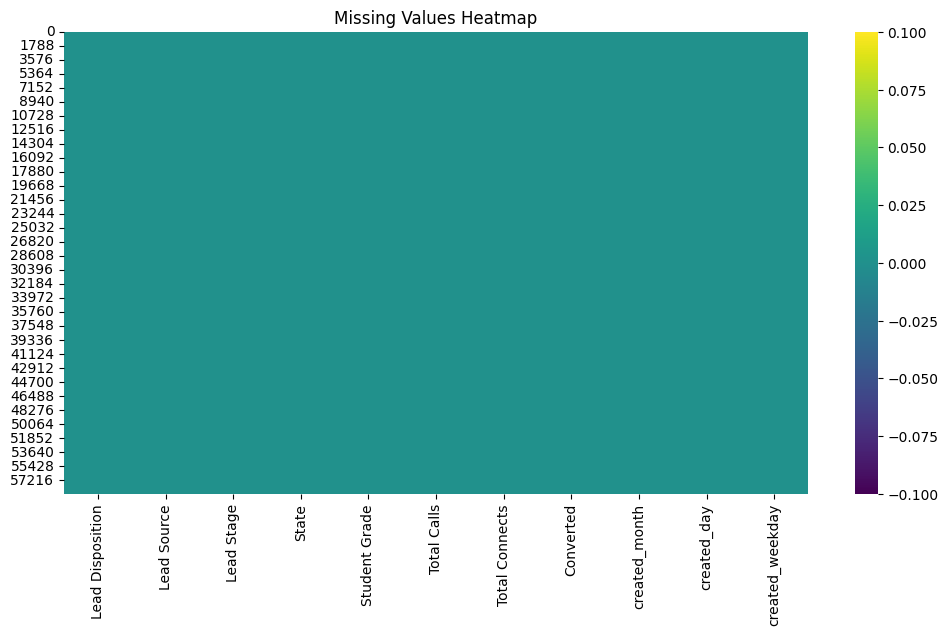

In [127]:
#Check where data is missing to decide how to handle it
plt.figure(figsize=(12,6))
sns.heatmap(df_clean.isnull(), cbar=True, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()


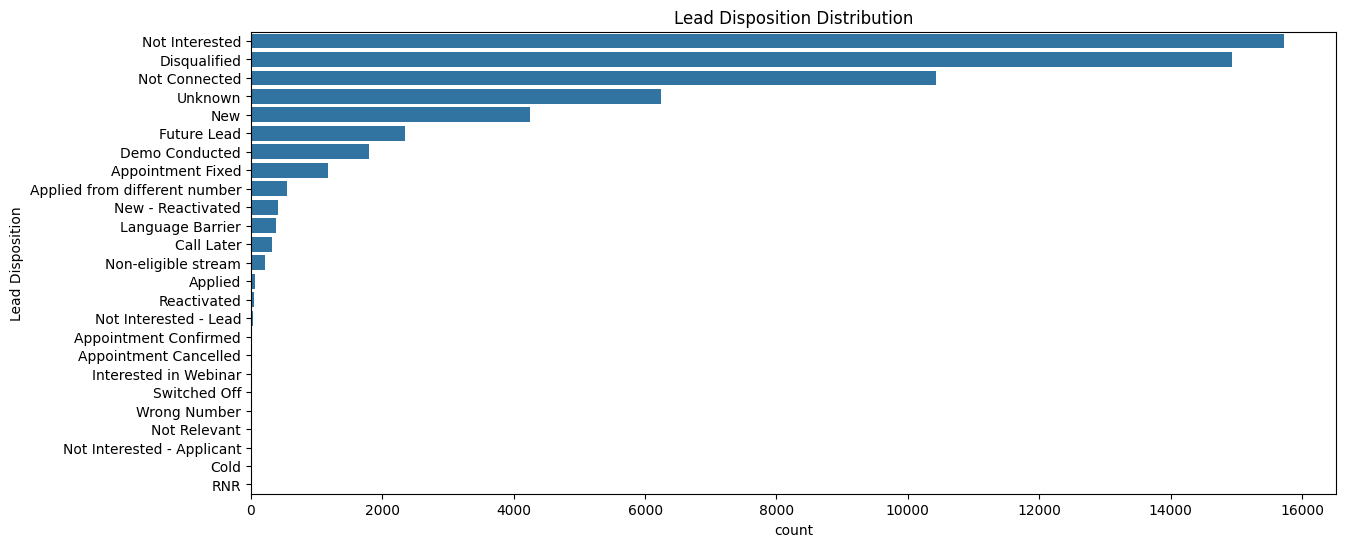

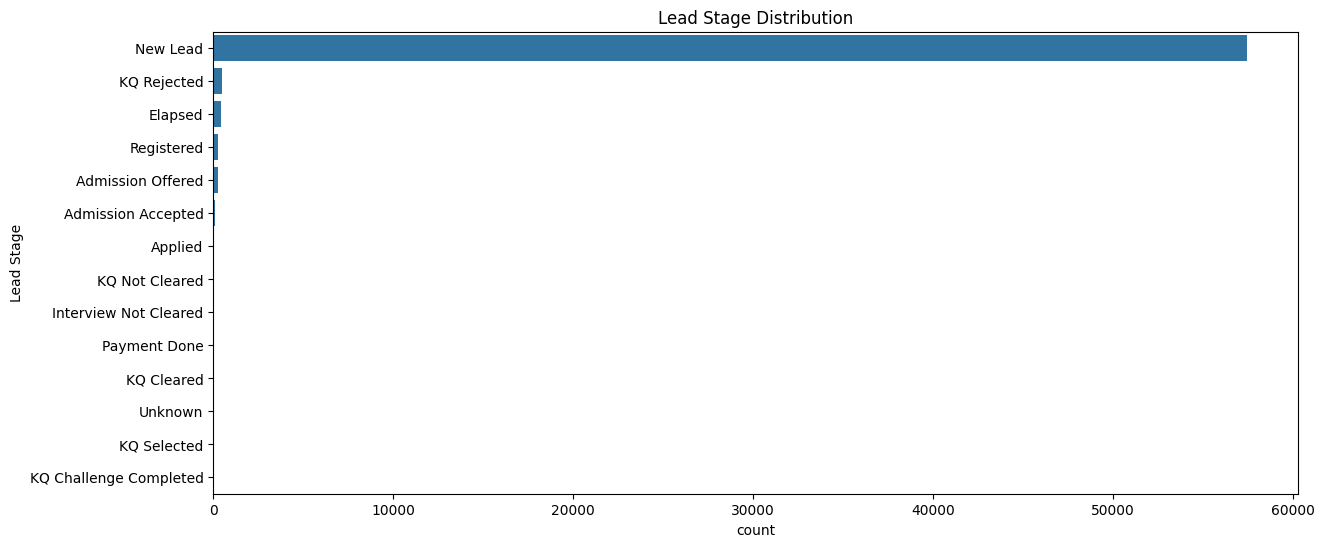

In [128]:
#Distribution of Key Categorical Columns
plt.figure(figsize=(14,6))
sns.countplot(y='Lead Disposition', data=df_clean, order=df_clean['Lead Disposition'].value_counts().index)
plt.title('Lead Disposition Distribution')
plt.show()

plt.figure(figsize=(14,6))
sns.countplot(y='Lead Stage', data=df_clean, order=df_clean['Lead Stage'].value_counts().index)
plt.title('Lead Stage Distribution')
plt.show()


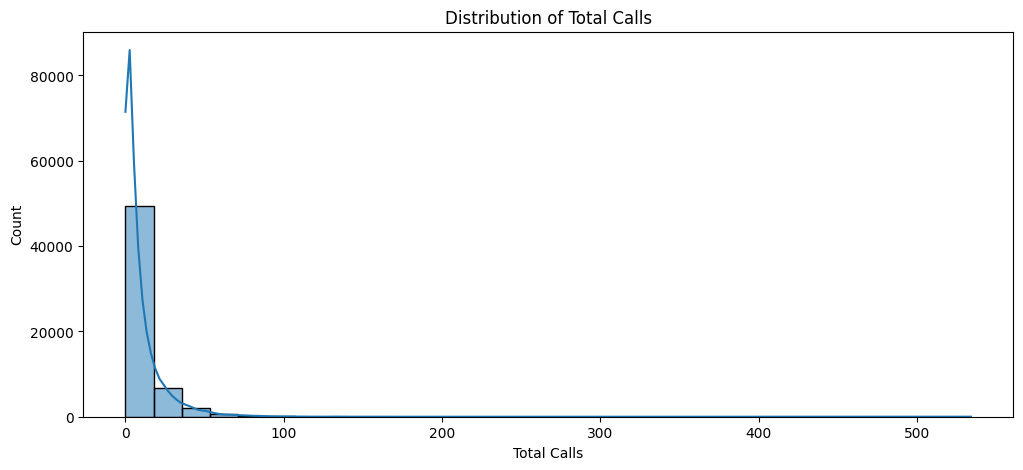

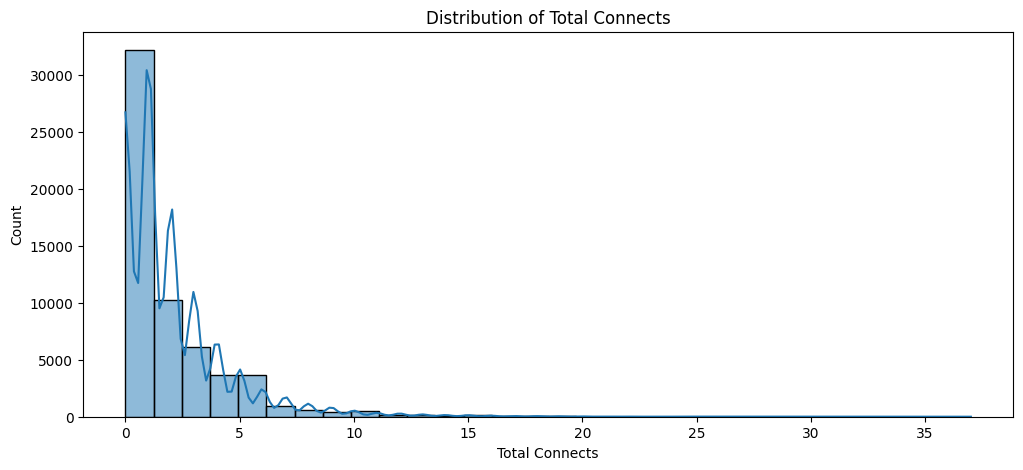

In [129]:
#Distribution of Numeric Variables
plt.figure(figsize=(12,5))
sns.histplot(df_clean['Total Calls'], bins=30, kde=True)
plt.title('Distribution of Total Calls')
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df_clean['Total Connects'], bins=30, kde=True)
plt.title('Distribution of Total Connects')
plt.show()


Conversion Rate Overall Mean: 0.4588448755341518
Total Converted leads vs not Converted: Converted
0    31913
1    27059
Name: count, dtype: int64


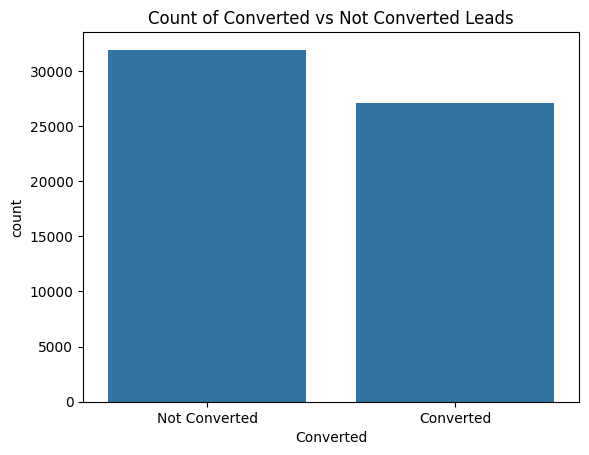

In [131]:
#Summary Statistics & Distribution of Converted Leads
# Basic stats on conversion
print("Conversion Rate Overall Mean:", df_clean['Converted'].mean())

# Count of converted vs not converted
print("Total Converted leads vs not Converted:", df_clean['Converted'].value_counts())

sns.countplot(data=df_clean, x='Converted')
plt.title('Count of Converted vs Not Converted Leads')
plt.xticks([0,1], ['Not Converted', 'Converted'])
plt.show()


Conversion Rate by Lead Disposition:
Lead Disposition
Appointment Cancelled            1.000000
Cold                             1.000000
Appointment Confirmed            1.000000
Not Relevant                     1.000000
Interested in Webinar            1.000000
Non-eligible stream              0.995192
Appointment Fixed                0.985520
Demo Conducted                   0.981132
Call Later                       0.944785
Applied from different number    0.943327
Applied                          0.939394
Not Interested                   0.831839
Not Interested - Lead            0.600000
New - Reactivated                0.584951
Reactivated                      0.522727
Switched Off                     0.500000
Not Interested - Applicant       0.500000
Not Connected                    0.421553
New                              0.260583
Wrong Number                     0.250000
Disqualified                     0.246601
Future Lead                      0.166241
Language Barrier      

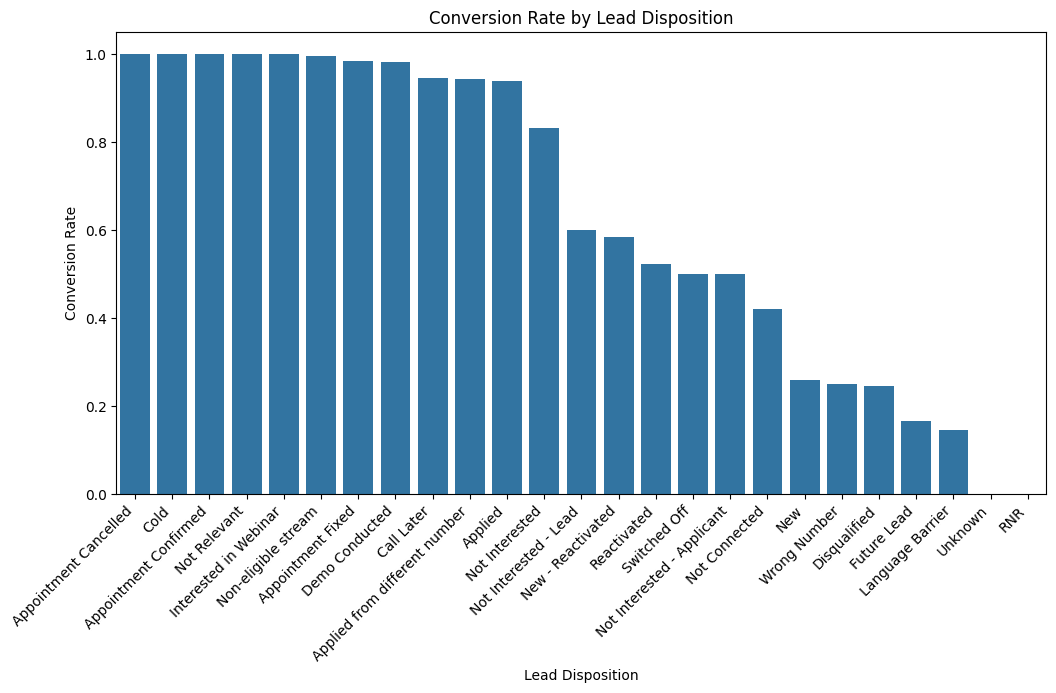

In [135]:
#Conversion Rate by Lead Disposition
conv_by_disposition = df_clean.groupby('Lead Disposition')['Converted'].mean().sort_values(ascending=False)

print("Conversion Rate by Lead Disposition:")
print(conv_by_disposition)

plt.figure(figsize=(12,6))
sns.barplot(x=conv_by_disposition.index, y=conv_by_disposition.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Lead Disposition')
plt.show()


Conversion Rate by Lead Stage:
Lead Stage
KQ Challenge Completed    1.000000
KQ Selected               1.000000
Payment Done              1.000000
KQ Rejected               0.963675
Applied                   0.956522
Registered                0.952191
Admission Offered         0.941909
KQ Not Cleared            0.937500
Elapsed                   0.922374
Admission Accepted        0.842857
Interview Not Cleared     0.714286
KQ Cleared                0.666667
New Lead                  0.446116
Unknown                   0.000000
Name: Converted, dtype: float64


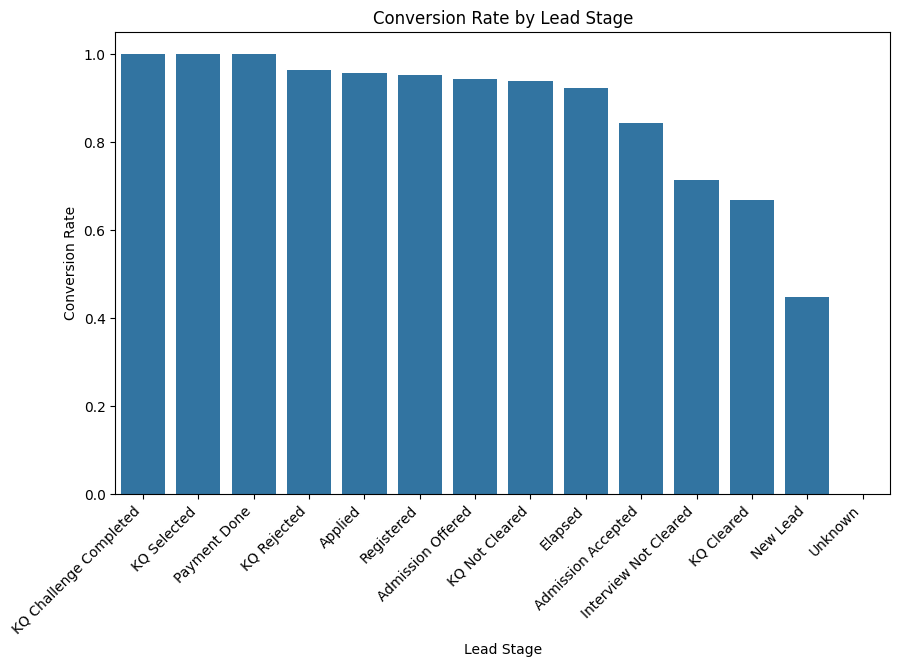

In [136]:
#Conversion Rate by Lead Stage
conv_by_stage = df_clean.groupby('Lead Stage')['Converted'].mean().sort_values(ascending=False)

print("Conversion Rate by Lead Stage:")
print(conv_by_stage)

plt.figure(figsize=(10,6))
sns.barplot(x=conv_by_stage.index, y=conv_by_stage.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Lead Stage')
plt.show()


Conversion Rate by Top 10 States:
State
Telangana         0.580402
Kerala            0.522405
Tamil Nadu        0.515955
Karnataka         0.414027
Andhra Pradesh    0.389983
Madhya Pradesh    0.383448
Uttar Pradesh     0.382244
North India       0.366802
West Bengal       0.360075
Rajasthan         0.340691
Name: Converted, dtype: float64


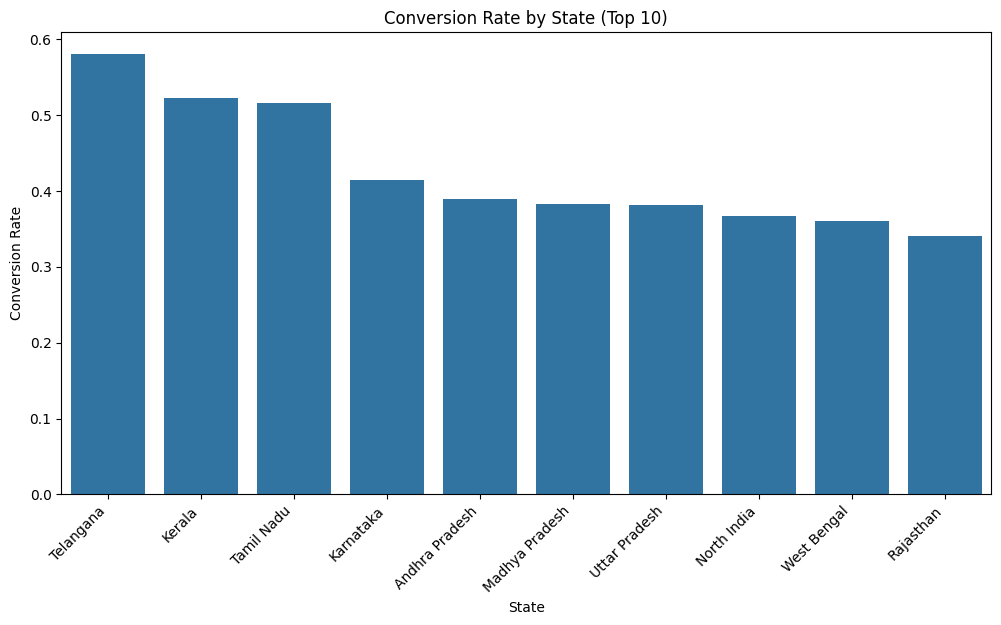

In [137]:
#Conversion Rate by State (top 10 states by lead count)
top_states = df_clean['State'].value_counts().head(10).index

conv_by_state = df_clean[df_clean['State'].isin(top_states)].groupby('State')['Converted'].mean().sort_values(ascending=False)

print("Conversion Rate by Top 10 States:")
print(conv_by_state)

plt.figure(figsize=(12,6))
sns.barplot(x=conv_by_state.index, y=conv_by_state.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by State (Top 10)')
plt.show()


Conversion Rate by Month:
created_month
1    0.587152
2    0.608803
3    0.382800
4    0.433120
5    0.519046
6    0.427278
7    0.376613
8    0.316573
9    0.250000
Name: Converted, dtype: float64


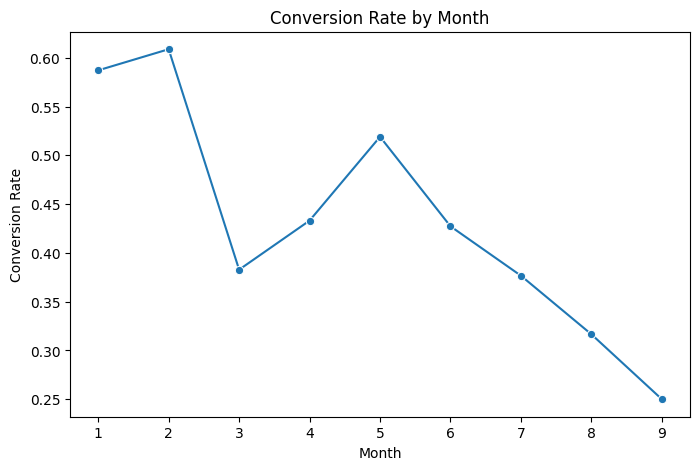

In [138]:
#Conversion Rate over Months
conv_by_month = df_clean.groupby('created_month')['Converted'].mean()

print("Conversion Rate by Month:")
print(conv_by_month)

plt.figure(figsize=(8,5))
sns.lineplot(x=conv_by_month.index, y=conv_by_month.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Month')
plt.show()


Behavioral Metrics

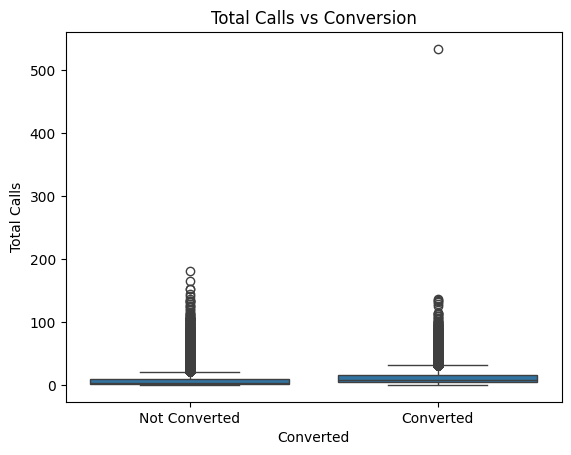

In [139]:
# Total Calls vs Conversion
#Hypothesis: More calls might correlate with higher conversion rate
sns.boxplot(data=df_clean, x='Converted', y='Total Calls')
plt.xticks([0,1], ['Not Converted', 'Converted'])
plt.title('Total Calls vs Conversion')
plt.show()


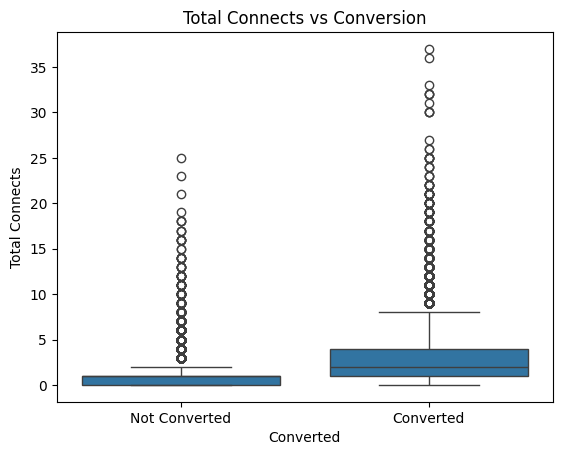

In [140]:
#Total Connects vs Conversion
#Hypothesis: Leads that were successfully connected with (vs just called) are more likely to convert
sns.boxplot(data=df_clean, x='Converted', y='Total Connects')
plt.xticks([0,1], ['Not Converted', 'Converted'])
plt.title('Total Connects vs Conversion')
plt.show()


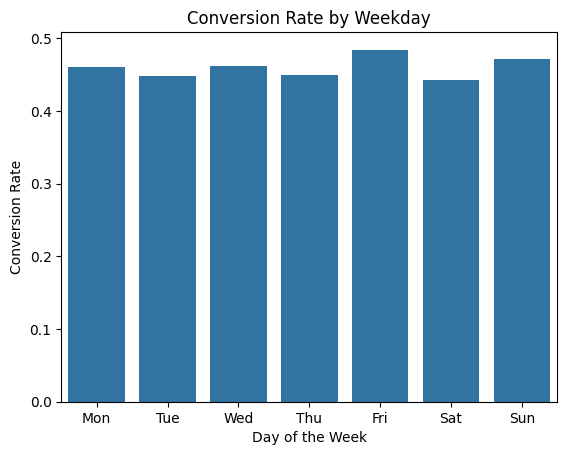

In [141]:
#Weekday vs Conversion
#Hypothesis: Leads created on certain weekdays may have higher conversion rates (e.g., weekends vs weekdays)

weekday_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df_clean['created_weekday_name'] = df_clean['created_weekday'].map(weekday_map)

conv_by_day = df_clean.groupby('created_weekday_name')['Converted'].mean().reindex(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

sns.barplot(x=conv_by_day.index, y=conv_by_day.values)
plt.title('Conversion Rate by Weekday')
plt.ylabel('Conversion Rate')
plt.xlabel('Day of the Week')
plt.show()


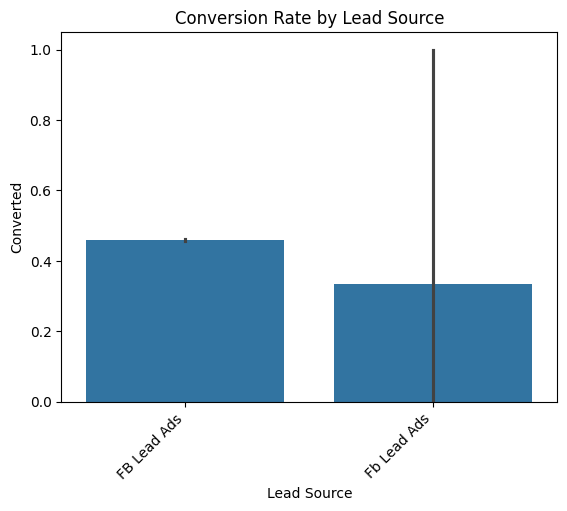

In [142]:
#Lead Source
#Which marketing channels bring the highest-converting leads?
top_sources = df_clean['Lead Source'].value_counts().head(10).index
df_top_sources = df_clean[df_clean['Lead Source'].isin(top_sources)]

sns.barplot(data=df_top_sources, x='Lead Source', y='Converted')
plt.xticks(rotation=45, ha='right')
plt.title('Conversion Rate by Lead Source')
plt.show()


Feature Engineering Plan: all about transforming raw data into features that better represent the underlying problem for predictive modeling.

Binary/One-Hot Encoding for Categorical Features
Categorical columns in the Dataset:

'Lead Disposition'

'Lead Source'

'Lead Stage'

'State'

'Student Grade'

In [143]:
#one-hot encoding categorical variables
categorical_cols = ['Lead Disposition', 'Lead Source', 'Lead Stage', 'State', 'Student Grade']
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)
print(df_encoded.head())

   Total Calls  Total Connects  Converted  created_month  created_day  \
0         15.0             6.0          1              4           17   
1          5.0             0.0          0              1            8   
2          3.0             2.0          0              6           15   
3         36.0             4.0          1              6           18   
4         49.0             5.0          1              6           19   

   created_weekday created_weekday_name  \
0                2                  Wed   
1                0                  Mon   
2                5                  Sat   
3                1                  Tue   
4                2                  Wed   

   Lead Disposition_Applied from different number  \
0                                           False   
1                                           False   
2                                           False   
3                                           False   
4                                    

In [144]:
#Normalizing Skewed Numerical Features
df_encoded['log_calls'] = np.log1p(df_clean['Total Calls'])
df_encoded['log_connects'] = np.log1p(df_clean['Total Connects'])


In [145]:
#drop the original columns
df_encoded.drop(['Total Calls', 'Total Connects'], axis=1, inplace=True)
print(df_encoded.head())

   Converted  created_month  created_day  created_weekday  \
0          1              4           17                2   
1          0              1            8                0   
2          0              6           15                5   
3          1              6           18                1   
4          1              6           19                2   

  created_weekday_name  Lead Disposition_Applied from different number  \
0                  Wed                                           False   
1                  Mon                                           False   
2                  Sat                                           False   
3                  Tue                                           False   
4                  Wed                                           False   

   Lead Disposition_Appointment Cancelled  \
0                                   False   
1                                   False   
2                                   False   
3       

Extract Temporal Categories
You've already extracted:

created_month

created_day

created_weekday

In [146]:
#Convert created_month and created_weekday into categorical dummies if you suspect patterns differ across time

df_encoded = pd.get_dummies(df_encoded, columns=['created_month', 'created_weekday'], drop_first=True)
print(df_encoded.head())

   Converted  created_day created_weekday_name  \
0          1           17                  Wed   
1          0            8                  Mon   
2          0           15                  Sat   
3          1           18                  Tue   
4          1           19                  Wed   

   Lead Disposition_Applied from different number  \
0                                           False   
1                                           False   
2                                           False   
3                                           False   
4                                           False   

   Lead Disposition_Appointment Cancelled  \
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   

   Lead Disposition_Appointment Confirmed  Lead Disposition_Appointment Fixed  \
0                           

In [147]:
# create interaction terms if needed later
df_encoded['calls_x_connects'] = df_encoded['log_calls'] * df_encoded['log_connects']
print(df_encoded.head())

   Converted  created_day created_weekday_name  \
0          1           17                  Wed   
1          0            8                  Mon   
2          0           15                  Sat   
3          1           18                  Tue   
4          1           19                  Wed   

   Lead Disposition_Applied from different number  \
0                                           False   
1                                           False   
2                                           False   
3                                           False   
4                                           False   

   Lead Disposition_Appointment Cancelled  \
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   

   Lead Disposition_Appointment Confirmed  Lead Disposition_Appointment Fixed  \
0                           

In [ ]:
#check that the Converted column is intact and ready as the target variable
target = 'Converted'
X = df_encoded.drop(columns=[target])
y = df_encoded[target]
print(X.head())
print(y.head())

   created_day created_weekday_name  \
0           17                  Wed   
1            8                  Mon   
2           15                  Sat   
3           18                  Tue   
4           19                  Wed   

   Lead Disposition_Applied from different number  \
0                                           False   
1                                           False   
2                                           False   
3                                           False   
4                                           False   

   Lead Disposition_Appointment Cancelled  \
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   

   Lead Disposition_Appointment Confirmed  Lead Disposition_Appointment Fixed  \
0                                   False                               False   
1            

In [149]:
#Final Shape & Sanity Check
print("Feature matrix shape:", X.shape)
print("Target distribution:\n", y.value_counts(normalize=True))


Feature matrix shape: (58972, 1907)
Target distribution:
 Converted
0    0.541155
1    0.458845
Name: proportion, dtype: float64


In [150]:
#Save Cleaned Dataset for Reuse
df_encoded.to_csv('engineered_data.csv', index=False)
print("Cleaned dataset saved as 'engineered_data.csv'")

Cleaned dataset saved as 'engineered_data.csv'


Model Building Pipeline

In [ ]:
# Convert categorical columns to dummy variables
df_encoded = pd.get_dummies(df_clean, drop_first=True)

# Define features and target
X = df_encoded.drop('Converted', axis=1)
y = df_encoded['Converted']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (47177, 1899)
Test shape: (11795, 1899)


Initial Models:

Logistic Regression (for baseline)

Random Forest (for robustness)

In [152]:
# 1. Train-test split (assuming X and y are already defined)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Initialize the scaler and scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# 4. Evaluate the model
train_score = model.score(X_train_scaled, y_train)
test_score = model.score(X_test_scaled, y_test)

print(f"Train Accuracy: {train_score:.2f}")
print(f"Test Accuracy: {test_score:.2f}")

Train Accuracy: 0.85
Test Accuracy: 0.84


In [153]:
#Training a Random Forest Classifier

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate
train_score_rf = rf_model.score(X_train_scaled, y_train)
test_score_rf = rf_model.score(X_test_scaled, y_test)

print(f"Random Forest - Train Accuracy: {train_score_rf:.2f}")
print(f"Random Forest - Test Accuracy: {test_score_rf:.2f}")


Random Forest - Train Accuracy: 0.99
Random Forest - Test Accuracy: 0.84


Observations:
Logistics Regression has good generalization without any signs of overfitting.
Random Forest: Generalizes well, similar to LogisticRegression.
Interpretaion:
Logistic Regression & Random Forest:  show balanced train and test accuracy (~85% and ~84%), which is a good sign of generalization and indicatntive of  capturing patterns in the data without memorizing it.



In [156]:
#model evaluation
def evaluate_model(model, X_test, y_test, model_name='Model'):
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Classification Report
    print(f"\n{model_name} - Classification Report:\n")
    print(classification_report(y_test, y_pred))

    # ROC-AUC Curve
    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        plt.plot([0,1],[0,1],'--', color='gray')
        plt.title(f"{model_name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()


In [ ]:


# Fit model if not done yet
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Plot importance
xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()



 Logistic Regression - Test Accuracy: 0.78

 Confusion Matrix:
[[5217 1166]
 [1413 3999]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      6383
           1       0.77      0.74      0.76      5412

    accuracy                           0.78     11795
   macro avg       0.78      0.78      0.78     11795
weighted avg       0.78      0.78      0.78     11795



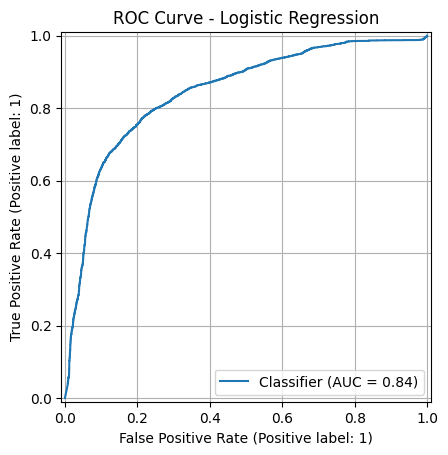

{'Model': 'Logistic Regression',
 'Accuracy': 0.7813480288257736,
 'Precision': 0.7742497579864472,
 'Recall': 0.7389135254988913,
 'F1-score': 0.7561690460433015,
 'AUC': np.float64(0.8439882811871287)}

In [ ]:


# Convert scaled test set to DataFrame with correct feature names
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# Use this instead for evaluation
evaluate_model(lr_model, X_test_scaled_df, y_test, model_name="Logistic Regression")


In [159]:
print([var for var in globals() if not var.startswith("__")])


['_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '_i', '_ii', '_iii', '_i1', '_i2', 'train_test_split', '_i3', '_i4', '_i5', 'pd', 'np', 'plt', 'sns', '_i6', 'load_dataset', 'ds', '_i7', '_i8', 'df', '_i9', '_i10', '_i11', '_i12', '_i13', '_i14', 'df_clean', '_i15', '_i16', '_i17', 'cat_cols', '_i18', '_i19', 'sys', '_i20', '_i21', '_i22', '_i23', '_i24', '_i25', 'conv_by_disposition', '_i26', 'conv_by_stage', '_i27', 'top_states', 'conv_by_state', '_i28', 'conv_by_month', '_i29', '_i30', '_i31', 'weekday_map', 'conv_by_day', '_i32', 'top_sources', 'df_top_sources', '_i33', 'categorical_cols', 'df_encoded', '_i34', '_i35', '_i36', '_i37', '_i38', 'target', 'X', 'y', '_i39', '_i40', '_i41', 'X_train', 'X_test', 'y_train', 'y_test', '_i42', 'LogisticRegression', 'RandomForestClassifier', 'classification_report', 'confusion_matrix', '_i43', 'lr_model', '_43', '_i44', 'StandardScaler', 'roc_auc_score', 'roc_curve', 'GridSearchCV', 'accuracy_score', 'precision_


 Logistic Regression - Test Accuracy: 0.78

 Confusion Matrix:
[[5217 1166]
 [1413 3999]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      6383
           1       0.77      0.74      0.76      5412

    accuracy                           0.78     11795
   macro avg       0.78      0.78      0.78     11795
weighted avg       0.78      0.78      0.78     11795


 Random Forest - Test Accuracy: 0.84

 Confusion Matrix:
[[5365 1018]
 [ 886 4526]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      6383
           1       0.82      0.84      0.83      5412

    accuracy                           0.84     11795
   macro avg       0.84      0.84      0.84     11795
weighted avg       0.84      0.84      0.84     11795



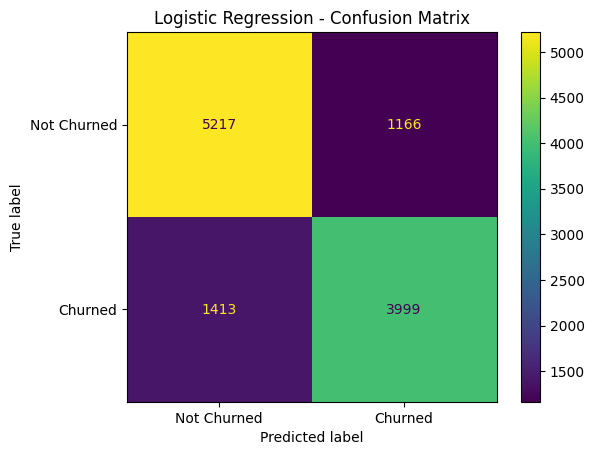

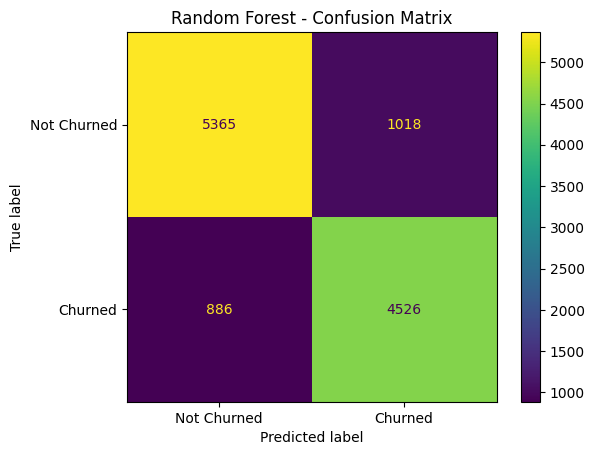

In [162]:


# Define the evaluation function (if not already defined)
def evaluate_model(model, X_test, y_test, model_name="Model"):
    print(f"\n {model_name} - Test Accuracy: {accuracy_score(y_test, model.predict(X_test)):.2f}")
    
    y_pred = model.predict(X_test)
    
    print("\n Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\n Classification Report:")
    print(classification_report(y_test, y_pred))
    
    #plot the confusion matrix
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["Not Churned", "Churned"])
    disp.ax_.set_title(f'{model_name} - Confusion Matrix')

#Fix the feature name warning for Logistic Regression
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# Evaluate both models
evaluate_model(lr_model, X_test_scaled_df, y_test, model_name="Logistic Regression")
evaluate_model(rf_model, X_test_scaled, y_test, model_name="Random Forest")


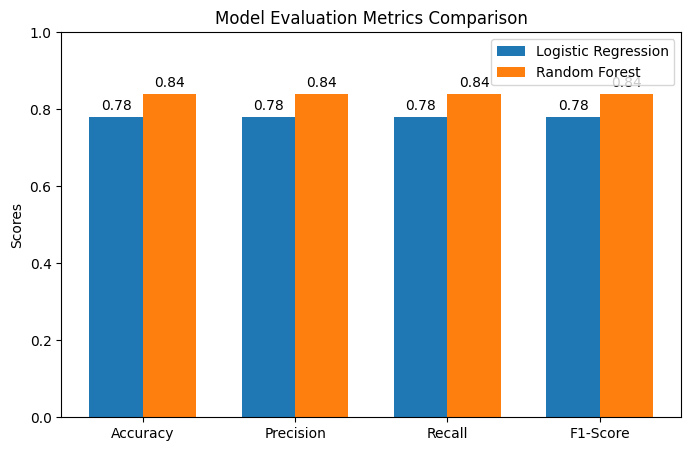

In [163]:

# Metrics from your output
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

logreg_scores = [0.78, (0.79+0.77)/2, (0.82+0.74)/2, (0.80+0.76)/2]  # averaging class 0 & 1 for precision, recall, f1
rf_scores = [0.84, (0.86+0.82)/2, (0.84+0.84)/2, (0.85+0.83)/2]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(x - width/2, logreg_scores, width, label='Logistic Regression')
bars2 = ax.bar(x + width/2, rf_scores, width, label='Random Forest')

ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0,1)
ax.legend()

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0,3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()


Interpretation of Model Results and Remarks
Logistic Regression
Accuracy 0.78: Correct predictions for 78% of test data.

Precision (avg ~0.78): When it predicts positive (class 1), about 78% are actually positive.

Recall (avg ~0.78): Captures about 78% of all actual positives.

F1-Score (avg ~0.78): Balanced measure of precision & recall.

Confusion Matrix:

True Negatives (TN): 5217 (correctly predicted 0)

False Positives (FP): 1166 (incorrectly predicted 1 when true is 0)

False Negatives (FN): 1413 (missed positives)

True Positives (TP): 3999 (correctly predicted 1)

Overall, Logistic Regression performs decently but has a notable number of false negatives and false positives.

Random Forest
Accuracy 0.84: Better overall accuracy (84% correct).

Precision (avg ~0.84): Higher confidence in positive predictions.

Recall (avg ~0.84): Captures more actual positives than Logistic Regression.

F1-Score (avg ~0.84): Better balanced performance.

Confusion Matrix:

TN: 5365 (better than Logistic Regression)

FP: 1018 (fewer false positives)

FN: 886 (significantly fewer false negatives)

TP: 4526 (more true positives found)

Random Forest shows stronger performance with fewer errors and better recall — important if missing positives is costly.

Summary
Random Forest outperforms Logistic Regression on all key metrics.

Logistic Regression is still reasonable and simpler but less accurate and precise.

Random Forest is the best opton if the goal is better predictive power, especially on identifying positives.

Logistic Regression is the best option if interpretability and simplicity matter more.

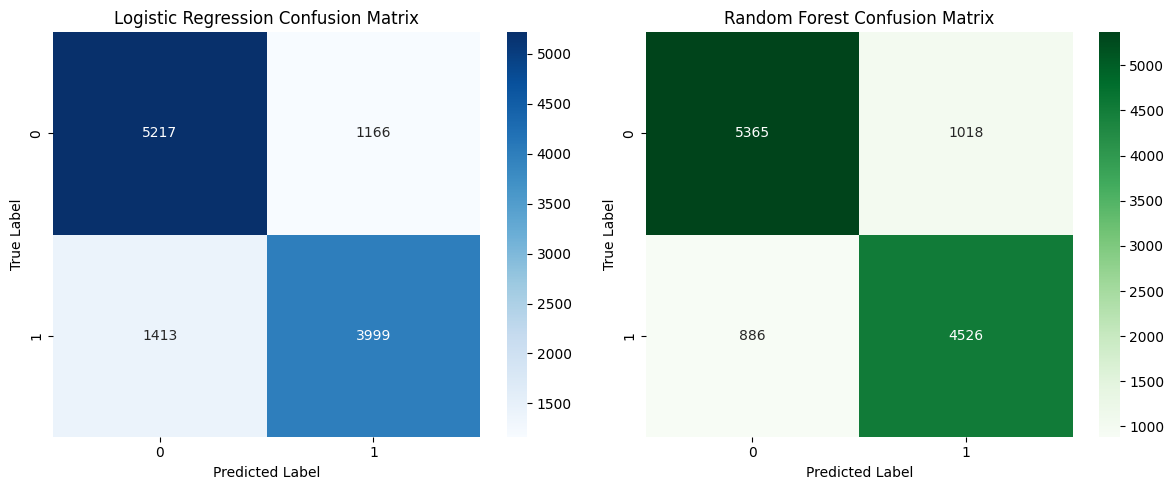

In [ ]:
#Side-by-Side Confusion Matrix Plots for the two models 

# Manually defining confusion matrices from your results
cm_logreg = [[5217, 1166],
            [1413, 3999]]

cm_rf = [[5365, 1018],
        [886, 4526]]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Random Forest Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()


c:\Users\Roche\Desktop\Leads Churn Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


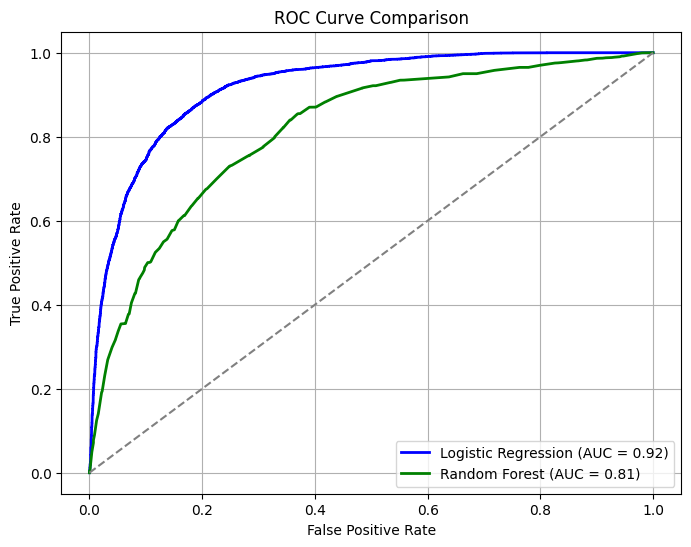

In [168]:

# Get predicted probabilities for positive class
lr_probs = lr_model.predict_proba(X_test)[:, 1]
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Observation from AUC Curve:
1. The curve plots the True Positive Rate (TPR) vs the False Positive Rate (FPR) at various classification thresholds.
2.  True Positive Rate (Recall): How many actual positives were correctly predicted.

3. False Positive Rate: How many actual negatives were incorrectly predicted as positive.

NB: A perfect model would hug the top-left corner (TPR = 1, FPR = 0), and the diagonal line represents random guessing.

Output Interpretation

AUC (Area Under the Curve)
Logistic Regression: AUC = 0.92

Random Forest: AUC = 0.81

AUC (Area Under the Curve) measures the overall ability of the model to distinguish between classes.

0.5 = random guess

1.0 = perfect model

Above 0.9 = excellent

<> Logistic Regression outperforms Random Forest here, as it has a higher AUC (0.92 vs. 0.81). It’s better at distinguishing between the churned and not churned classes in your test data.

<> Curve Shape
The blue curve (Logistic Regression) is consistently higher than the green one (Random Forest), especially in the low FPR region.

This indicates better performance at earlier thresholds, meaning Logistic Regression is more confident and accurate in making positive predictions.

Summary
Model	AUC Score	Interpretation
Logistic Regression	0.92	Excellent class separation
Random Forest	0.81	Good, but less effective than Logistic

Conclusion: Logistic Regression provides a stronger and more reliable separation between churned and retained leads than Random Forest. Even though earlier accuracy scores showed Random Forest at 0.84 and Logistic at 0.78, AUC gives a fuller picture—especially in imbalanced or nuanced datasets.


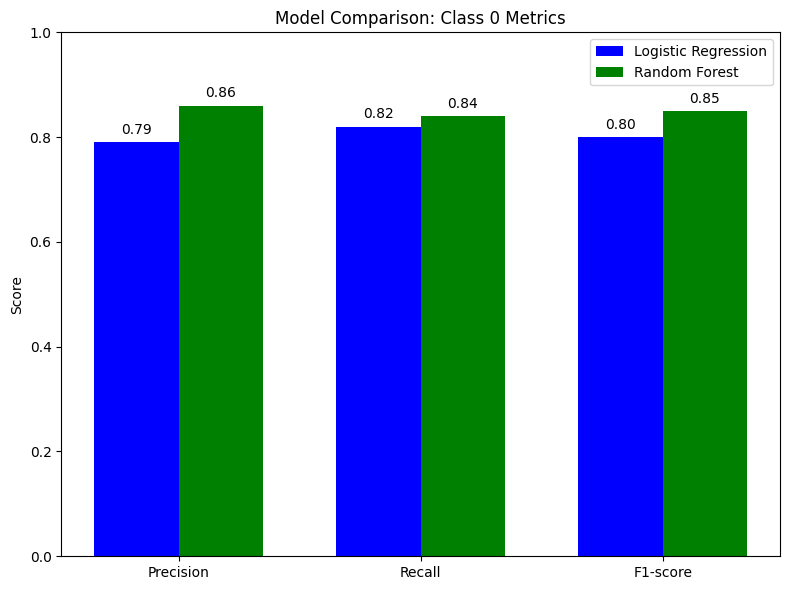

In [ ]:
#bar chart comparing precision, recall, and f1-score for both models, Class 0

# Metrics from classification report
metrics = ['Precision', 'Recall', 'F1-score']
logistic_scores = [0.79, 0.82, 0.80]  # for class 0
random_forest_scores = [0.86, 0.84, 0.85]  # for class 0

x = np.arange(len(metrics))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, logistic_scores, width, label='Logistic Regression', color='blue')
bars2 = ax.bar(x + width/2, random_forest_scores, width, label='Random Forest', color='green')

# Labels and titles
ax.set_ylabel('Score')
ax.set_title('Model Comparison: Class 0 Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()

# Annotate bars with values
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Observation:

Random Forest performs better across all metrics.

Logistic Regression trails slightly behind but still performs reasonably well.

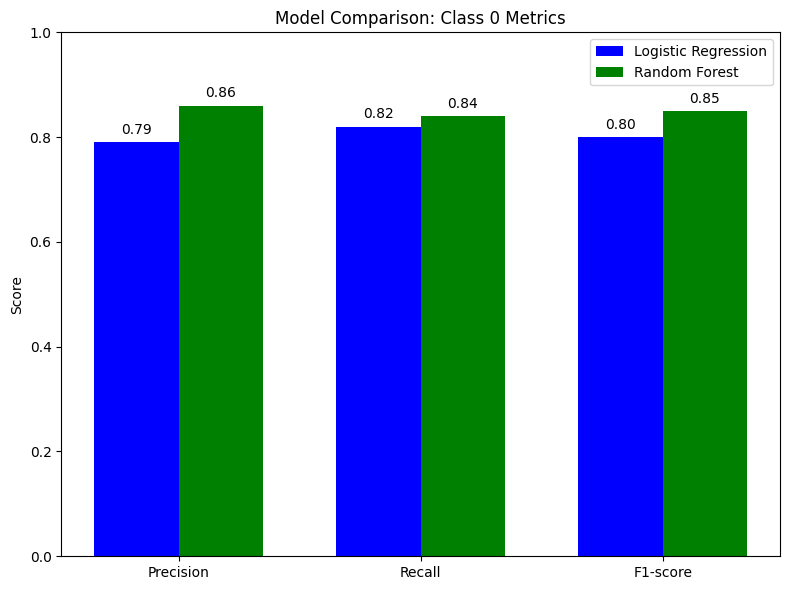

In [171]:
##bar chart comparing precision, recall, and f1-score for both models, Class 1
# Metrics from classification report
metrics = ['Precision', 'Recall', 'F1-score']
logistic_scores = [0.79, 0.82, 0.80]  # for class 0
random_forest_scores = [0.86, 0.84, 0.85]  # for class 0

x = np.arange(len(metrics))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, logistic_scores, width, label='Logistic Regression', color='blue')
bars2 = ax.bar(x + width/2, random_forest_scores, width, label='Random Forest', color='green')

# Labels and titles
ax.set_ylabel('Score')
ax.set_title('Model Comparison: Class 0 Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()

# Annotate bars with values
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Comparing both Class 0 and Class 1 based on the full classification report:
Logistic Regression:
Class 0 (Non-churners):

Precision: 0.79

Recall: 0.82

F1-score: 0.80

Class 1 (Churners):

Precision: 0.77

Recall: 0.74

F1-score: 0.76

Random Forest:
Class 0:

Precision: 0.86

Recall: 0.84

F1-score: 0.85

Class 1:

Precision: 0.82

Recall: 0.84

F1-score: 0.83

Observations:
Random Forest performs better across both classes, not just Class 0:

For Class 1 (churners), Random Forest has higher precision and recall than Logistic Regression.

This means it is better at correctly identifying churners and makes fewer mistakes when predicting churn.

Logistic Regression tends to underperform in both classes:

It has a slightly more balanced but weaker performance overall.

It might still be useful if model interpretability is critical.

Business Impact:

Higher recall for churners (Class 1) in Random Forest means you're less likely to miss customers who are at risk of leaving — this is critical for churn prevention.

Higher precision means you won’t waste resources targeting users who were never at risk.

Conclusion:
Random Forest is the better-performing model for both churners and non-churners — it should be your primary model for deployment or reporting.

Comparing confusion matrices for the two models:

Logistic Regression
[[5217 1166]   → Actual Class 0: 5217 correct, 1166 false positives
[1413 3999]]  → Actual Class 1: 3999 correct, 1413 false negatives

Random Forest
[[5365 1018]   → Actual Class 0: 5365 correct, 1018 false positives
[ 886 4526]]  → Actual Class 1: 4526 correct, 886 false negatives

Observations by Class:
Class 0 (Non-churners):
Random Forest makes fewer mistakes predicting Class 0 (only 1018 false positives vs. 1166 for Logistic Regression).

Slightly better true negatives and precision for Class 0 in Random Forest.

Class 1 (Churners):
Random Forest also outperforms here:

More true positives: 4526 vs. 3999

Fewer false negatives: 886 vs. 1413

This results in higher recall and precision for identifying actual churners.

Insights Summary:
Metric	Logistic Regression	Random Forest
AUC (ROC Curve)	0.92	0.81
Test Accuracy	78%	84%
Class 0 F1-score	0.80	0.85
Class 1 F1-score	0.76	0.83
Class 0 False Positives	1166	 1018
Class 1 False Negatives	1413	 886

Random Forest is more accurate overall, and does a better job predicting both churners and non-churners, especially if you're working with class imbalance or want stronger precision/recall.

Logistic Regression, despite lower accuracy, is still useful where interpretability and ranking probability scores (AUC) are important.